## HW1  ANOVA 方差分析

| 姓名 | 学号 | 专业 |
| :-----| ----: | :----: |
| 肖文韬 | 2020214245 | 计算机技术 |

1. **(5 points) Recall and write down the assumptions which one-way ANOVA are based on.**

ANOVA 是方差分析（<ins>AN</ins>alysis <ins>O</ins>f <ins>VA</ins>riance）的缩写，又称 F 检验, 用于三个及以上样本均值差别的显著性检验。它基于以下假设：

* 所有的数据都是随机采样的。
* 每个组的方差是一样的（同调性），各组的标准差中最大和最小的比例不超过 $2∶1$。
* 残差是正态分布。

2. **(5 points) Focus on two columns columns: Category (Col\[2\]) and Average Age (Col\[7\]). Taking feature Average Age as an example, we want to measure whether the average age varied significantly across the categories. Clearly state the null (H0) and the alternative (H1) hypotheses for this task.**

定义相同 category 的样本属于同一个组（group）。

* H0: 所有组的均值都相等（$\mu_1 = \mu_2 = \cdots$)
* H1: 不是所有组的均值都相等。

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import normaltest
from scipy.stats import f_oneway
from scipy.stats import f
from scipy.stats import boxcox
from scipy.stats import yeojohnson
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats

# png for inline display, pdf for exporting to pdf (by LaTeX)
%matplotlib inline
mpl.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 4]
set_matplotlib_formats('png', 'pdf')

# Only Tested in Windows with Python 3.9
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# Bug @  ~\AppData\Roaming\Python\Python39\site-packages\xlrd\xlsx.py:L60
data = pd.read_excel('data.xlsx')

def hypothesis_test(p_value, alpha=.01):
    return (f'p_value = {p_value:.4e}' +
          (f' < {alpha} (Reject H0)' if p_value < alpha else
          f' > {alpha} (Accept H0)'))

p_value = 4.8348e-06 < 0.01 (Reject H0)


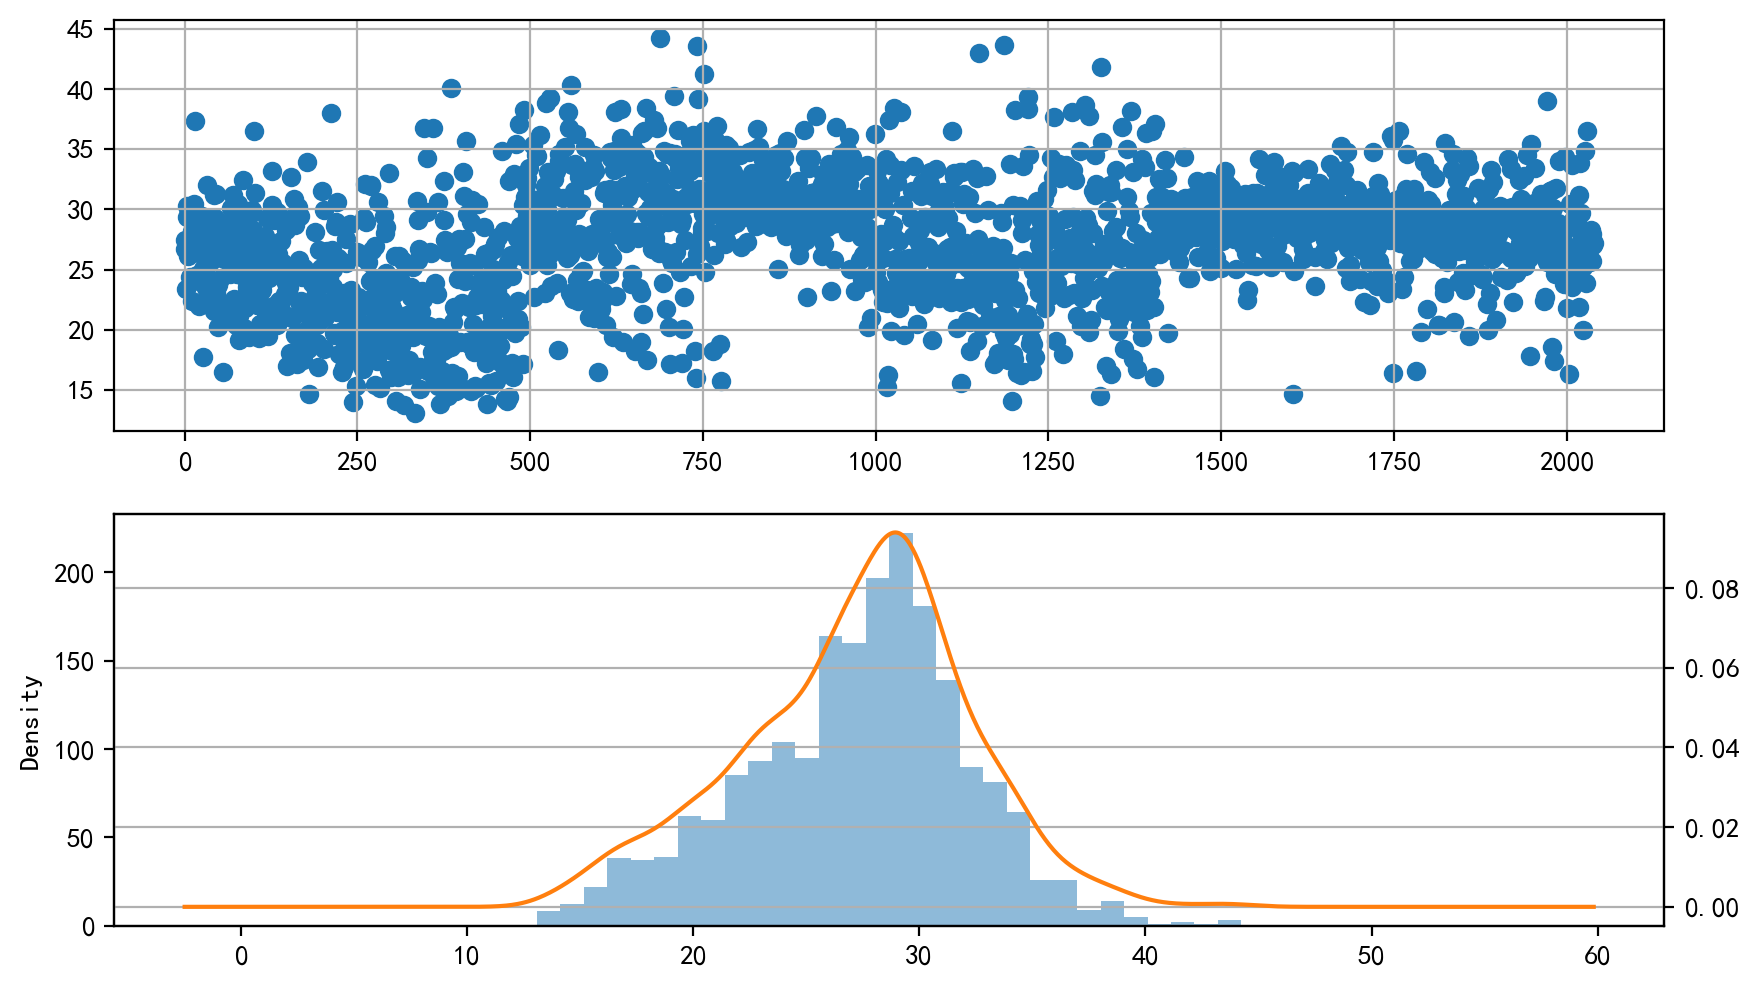

In [2]:
# Q3-(a)
_, p_value = normaltest(data['平均年龄'])
print(hypothesis_test(p_value))

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.scatter(data['平均年龄'].index, data['平均年龄'].values)
plt.grid()
ax2 = fig.add_subplot(2, 1, 2)
data['平均年龄'].hist(bins=30, alpha=0.5, ax=ax2)
# Note that kde (kernel density estimation) is not empirical pdf
data['平均年龄'].plot(kind='kde', secondary_y=True, ax=ax2)
plt.grid()
plt.show()

3. **Use your favorite statistics analysis software, like Matlab , R, Excel Excel, SPSS or …**

(a). **(10 points) Draw the empirical probability density funfction of Col\[7\], i.e. the empirical pdf of average age. Does the data in this dimension follow Gaussian distribution? Test normality of Col\[7\].**

Col\[7\] 的散点图和经验概率密度函数如上图所示。原假设（H0）假设数据符合正态分布。
设置显著性水平 $\alpha = 0.01$，通过计算 p-value $= 4.8348 \times 10^{−6} < 0.01$，所以拒绝假设 $H_0$, col\[7\] 不符合高斯分布。

In [3]:
# Q3-(b)
components = [[i, g['平均年龄']] for i, g in data[['群类别', '平均年龄']].groupby('群类别')]
# Test the normality
print('Normal Test:')
for gid, group in components:
    print(f'group {gid}: ' +
          f'{hypothesis_test(normaltest(group)[1])}')
    
# Test the homogeneity of variances
print('Homogeneity Test:')
stds = [[gid, group.std()] for gid, group in components]
print('\n'.join([f'group {i}: std = {v:.5f}' for i, v in stds]))
max_std, min_std = max(stds, key=lambda x: x[1])[1], min(stds, key=lambda x: x[1])[1]
ratio = max_std / min_std
print('Ratio of largest to smallest group std:\n' +
      f'{max_std:.5f} / {min_std:.5f} = {ratio:.5f} ' +
      ('> 2:1 (Reject Homogeneity)' if ratio >= 2 else
       '< 2:1 (Accept Homogeneity)'))

Normal Test:
group 1: p_value = 1.8686e-02 > 0.01 (Accept H0)
group 2: p_value = 6.3506e-02 > 0.01 (Accept H0)
group 3: p_value = 2.2356e-01 > 0.01 (Accept H0)
group 4: p_value = 5.3107e-04 < 0.01 (Reject H0)
group 5: p_value = 2.2267e-20 < 0.01 (Reject H0)
Homogeneity Test:
group 1: std = 4.92376
group 2: std = 5.21737
group 3: std = 2.55290
group 4: std = 5.09826
group 5: std = 3.01898
Ratio of largest to smallest group std:
5.21737 / 2.55290 = 2.04370 > 2:1 (Reject Homogeneity)


(b) **(10 points) In Col[7], there are 5 components divided by category labels labels. We denote the data in Col\[7\] with category $i$ (where $i = 1, \cdots , 5$) as Col\[7|categoty=i\]. Test the normality of each components and test the homogeneity of variances.**

设置显著性水平 $\alpha = 0.01$，计算得，组 1，2 和 3 符合正态性，组 4 和 5 不符合正态性。
同时，计算各组的标准差，最大的与最小的之比为 $2.0437$ 略大于 $2:1$，所以不符合同调性。

In [4]:
# Q3-(c)

def ANOVA(components):
    # Within-group statistic
    means, ns, vares = list(map(lambda x: np.array(x),
                                zip(*[[g.mean(), len(g), g.var()] for _, g in components])))
    grand_mean = sum(means * ns) / sum(ns)
    # Between-group Variation
    ssb = sum(ns * (means - grand_mean) ** 2)
    # Within-group Variation
    ssw = sum(ns * vares)
    # Between-group degree of freedom
    dfb = len(ns) - 1
    # Within-group degree of freedom
    dfw = sum(ns) - len(ns)
    # Mean of Squares
    msb = ssb / dfb
    msw = ssw / dfw
    # F Statistic
    f_stat = msb / msw
    p_value = f.pdf(f_stat, dfb, dfw)

    # Visualization
    df = pd.DataFrame({
        'Source': ['Between', 'Within', 'Total'],
        'SS': [ssb, ssw, ssb + ssw],
        'df': [dfb, dfw, dfb + dfw],
        'MS': [msb, msw, ''],
        'F': [f_stat, '', ''],
        'P': [p_value, '', '']
    })
    return df

ANOVA(components)

,Source,SS,df,MS,F,P
0,Between,12782.918190,4,3195.73,171.087,3.02173e-126
1,Within,38011.705928,2035,18.679,,
2,Total,50794.624118,2039,,,


(c) **(20 points) Do the one one-way ANOVA test for Col\[7\] with categories in Col\[2\]. Write down your conclusion, supporting statistics, and visualize your data which inspire the process.**

**结论**：在显著性水平 $\alpha = 0.01$ 下，因为计算得到 p-value $\approx 10^{−126} \ll 0.01$，所以拒绝原假设 $H_0$：各组的方差相同。
其计算过程和具体统计量在上表中展示，具体计算过程见上面代码。

Column: 地域集中度
Normal Test:
group 1: p_value = 2.4591e-19 < 0.01 (Reject H0)
group 2: p_value = 8.9781e-117 < 0.01 (Reject H0)
group 3: p_value = 1.7385e-18 < 0.01 (Reject H0)
group 4: p_value = 8.9032e-12 < 0.01 (Reject H0)
group 5: p_value = 0.0000e+00 < 0.01 (Reject H0)
Homogeneity Test:
Ratio of largest to smallest group std:
0.30106 / 0.15746 = 1.91205 < 2:1 (Accept Homogeneity)
Column: 年龄差
Normal Test:
group 1: p_value = 8.0359e-14 < 0.01 (Reject H0)
group 2: p_value = 9.8435e-01 > 0.01 (Accept H0)
group 3: p_value = 2.5022e-05 < 0.01 (Reject H0)
group 4: p_value = 4.1518e-19 < 0.01 (Reject H0)
group 5: p_value = 2.5103e-07 < 0.01 (Reject H0)
Homogeneity Test:
Ratio of largest to smallest group std:
2.59021 / 1.63019 = 1.58890 < 2:1 (Accept Homogeneity)
Column: 消息数
Normal Test:
group 1: p_value = 3.0680e-172 < 0.01 (Reject H0)
group 2: p_value = 2.2304e-78 < 0.01 (Reject H0)
group 3: p_value = 4.9374e-54 < 0.01 (Reject H0)
group 4: p_value = 1.1643e-151 < 0.01 (Reject H0)
group 5:

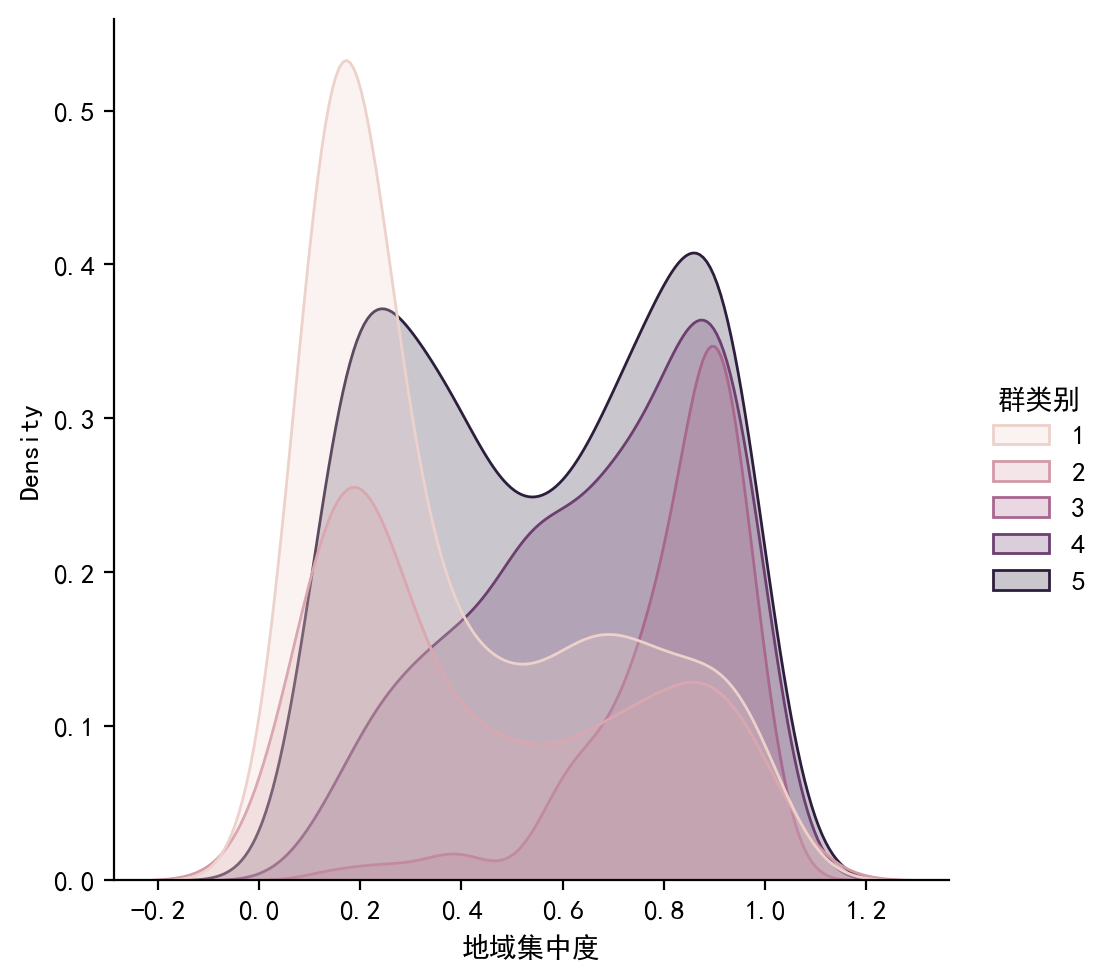

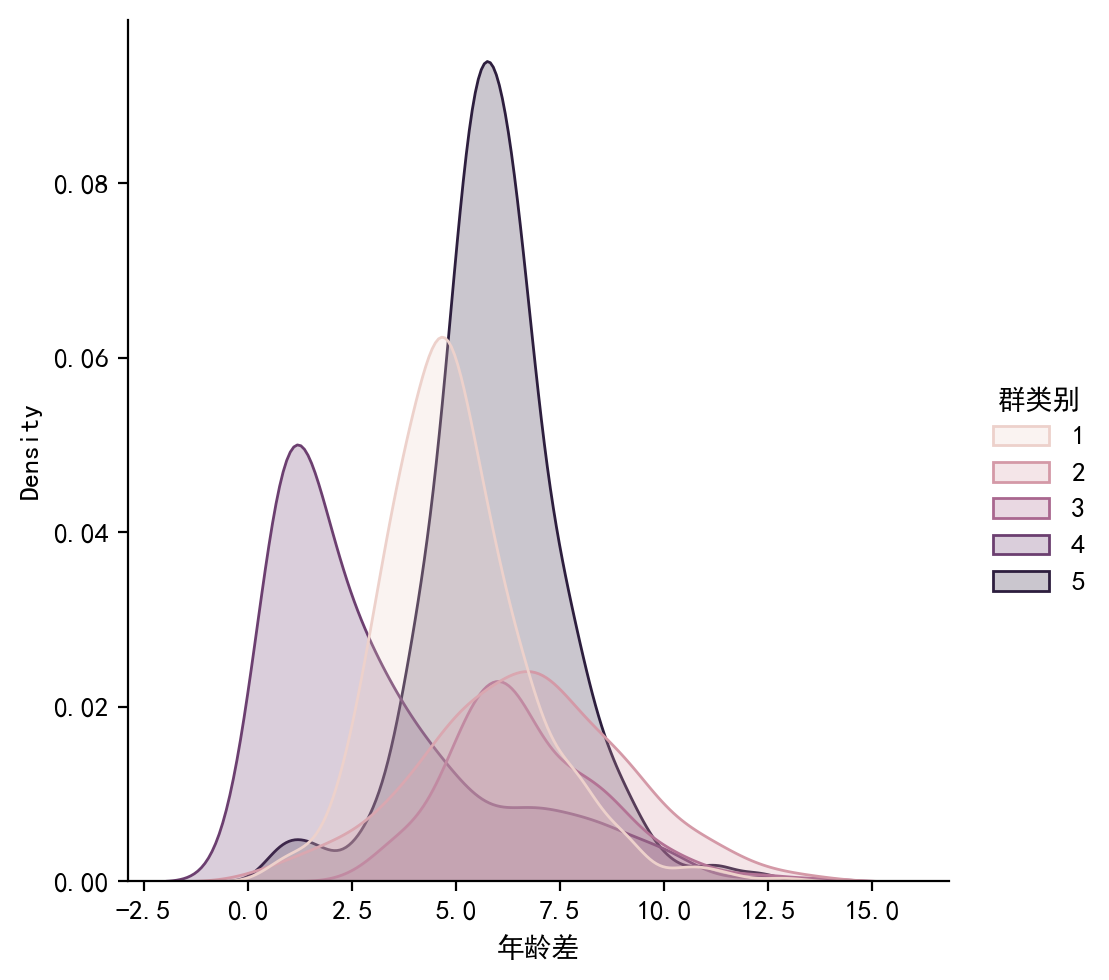

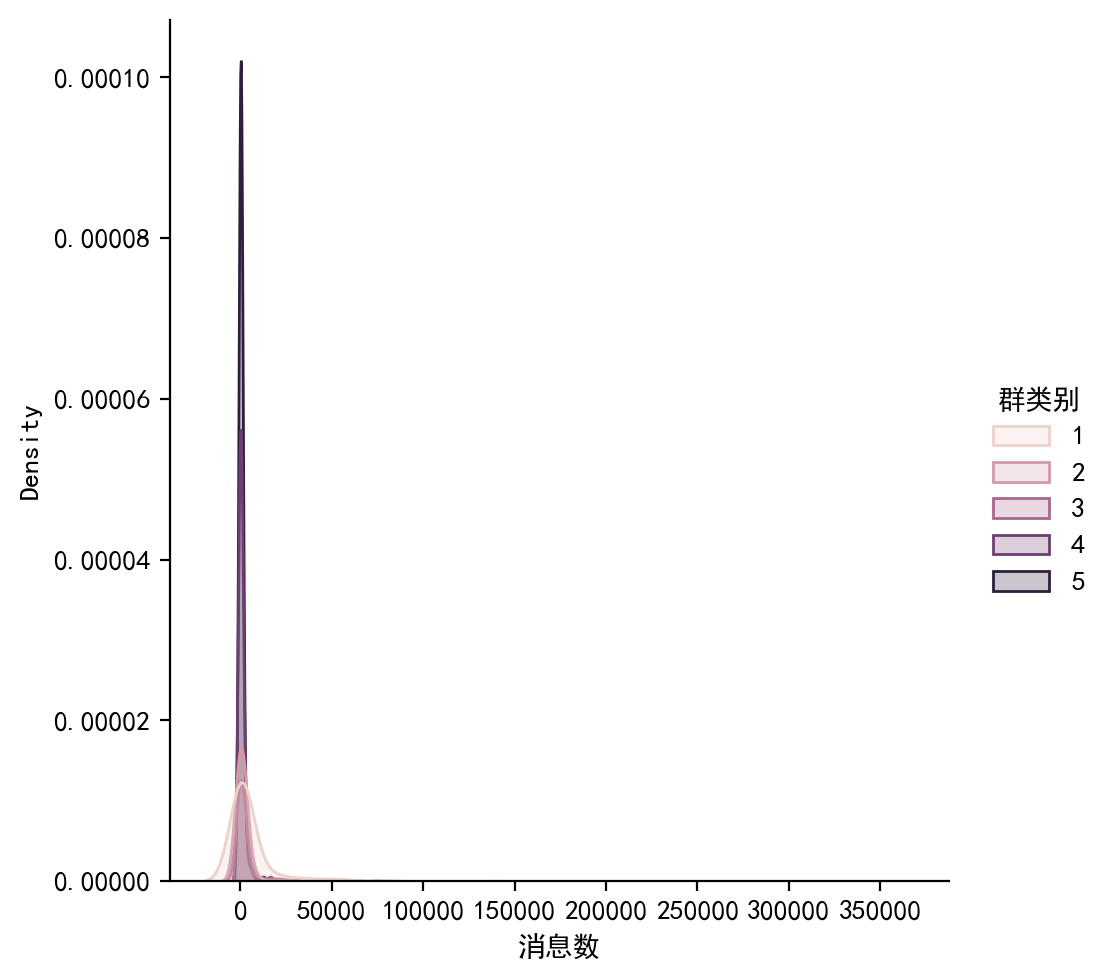

In [5]:
# Q4
cols = ['地域集中度', '年龄差', '消息数']

# fig = plt.figure(figsize=(10, 3 * len(cols)))
for idx_col, col in enumerate(cols):
    print(f'Column: {col}')
#     ax = fig.add_subplot(len(cols), 1, idx_col + 1)
#     ax.set_title(col)
#     data[col].hist(bins=30, alpha=0.5, ax=ax)
#     data[col].plot(kind='kde', secondary_y=True, ax=ax)
#     plt.grid()
    sns.displot(data, x=col, hue='群类别', kind='kde', fill=True)
    components = [[i, g[col]] for i, g in data[['群类别', col]].groupby('群类别')]
    # Test the normality
    print('Normal Test:')
    for gid, group in components:
        norm_test_res = hypothesis_test(normaltest(group)[1])
        print(f'group {gid}: {norm_test_res}')

    # Test the homogeneity of variances
    print('Homogeneity Test:')
    stds = [[gid, group.std()] for gid, group in components]
    max_std, min_std = max(stds, key=lambda x: x[1])[1], min(stds, key=lambda x: x[1])[1]
    ratio = max_std / min_std
    print('Ratio of largest to smallest group std:\n' +
          f'{max_std:.5f} / {min_std:.5f} = {ratio:.5f} ' +
          ('> 2:1 (Reject Homogeneity)' if ratio >= 2 else
           '< 2:1 (Accept Homogeneity)'))

# plt.show()

Column: 地域集中度
Normal Test:
group 1: p_value = 0.0000e+00 < 0.01 (Reject H0)
group 2: p_value = 5.8673e-152 < 0.01 (Reject H0)
group 3: p_value = 3.8105e-37 < 0.01 (Reject H0)
group 4: p_value = 5.7005e-22 < 0.01 (Reject H0)
group 5: p_value = 1.8550e-16 < 0.01 (Reject H0)
Homogeneity Test:
Ratio of largest to smallest group std:
0.75294 / 0.27516 = 2.73639 > 2:1 (Reject Homogeneity)
Column: 年龄差
Normal Test:
group 1: p_value = 3.4484e-24 < 0.01 (Reject H0)
group 2: p_value = 5.1473e-31 < 0.01 (Reject H0)
group 3: p_value = 4.2967e-01 > 0.01 (Accept H0)
group 4: p_value = 1.6691e-30 < 0.01 (Reject H0)
group 5: p_value = 6.1312e-83 < 0.01 (Reject H0)
Homogeneity Test:
Ratio of largest to smallest group std:
0.84474 / 0.28195 = 2.99607 > 2:1 (Reject Homogeneity)
Column: 消息数
Normal Test:
group 1: p_value = 4.7073e-13 < 0.01 (Reject H0)
group 2: p_value = 1.2898e-03 < 0.01 (Reject H0)
group 3: p_value = 2.4130e-01 > 0.01 (Accept H0)
group 4: p_value = 6.7512e-03 < 0.01 (Reject H0)
group 5: p

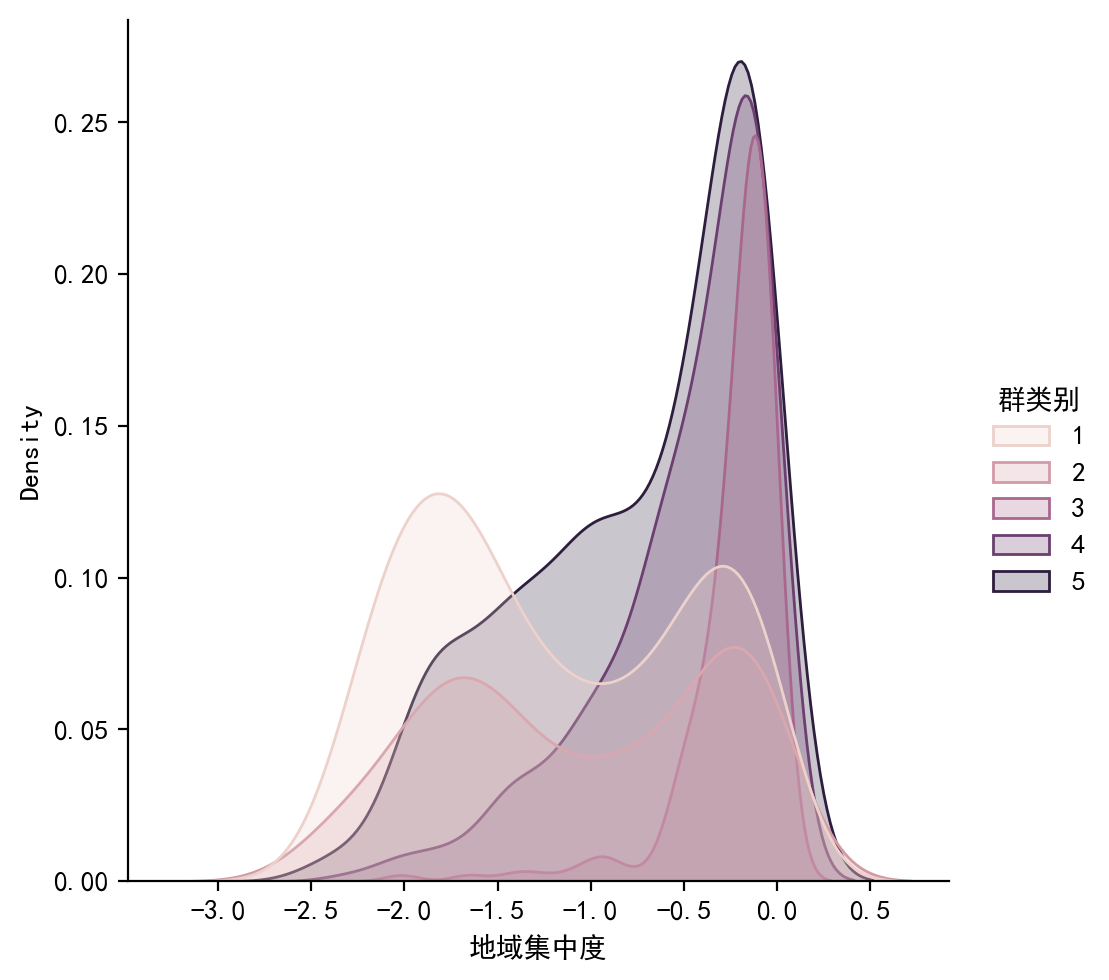

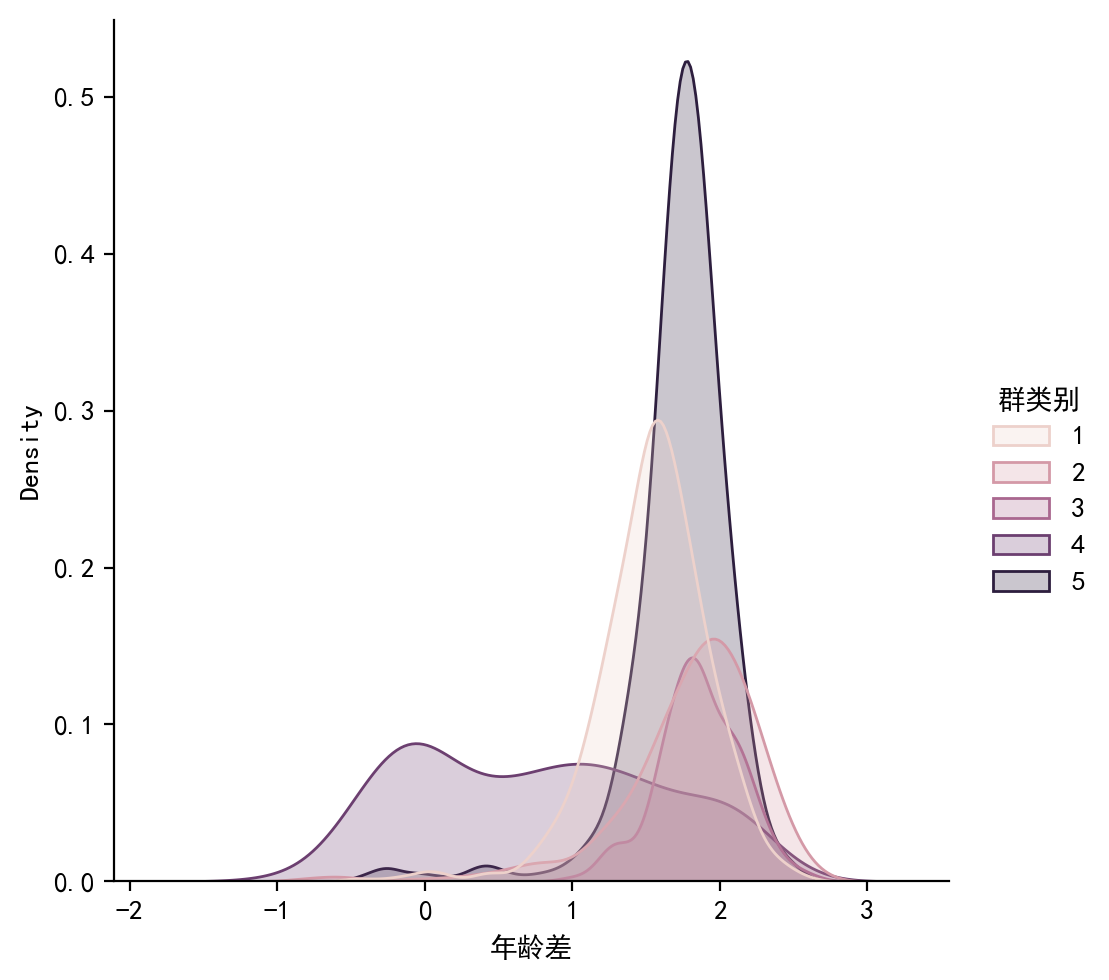

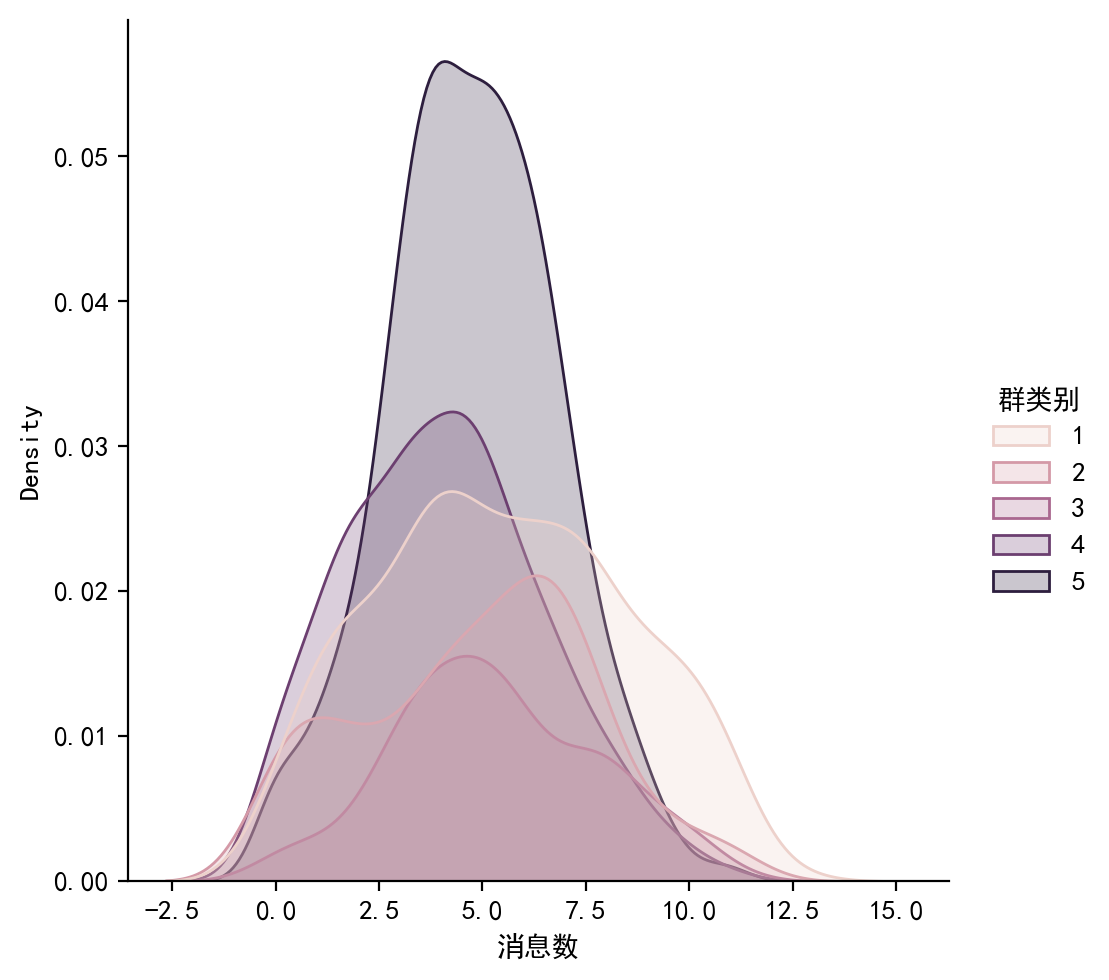

In [6]:
# Q4-log

for idx_col, col in enumerate(cols):
    print(f'Column: {col}')
    trans_cols = {c: (lambda x: np.log(x)) if c == col else
                  (lambda x: x) for c in data.columns}
    sns.displot(data.transform(trans_cols),
                x=col, hue='群类别', kind='kde', fill=True)
    components = [[i, g[col].transform(
        lambda x: np.log(x))] for i, g in data[['群类别', col]].groupby('群类别')]
    # Test the normality
    print('Normal Test:')
    for gid, group in components:
        norm_test_res = hypothesis_test(normaltest(group)[1])
        print(f'group {gid}: {norm_test_res}')

    # Test the homogeneity of variances
    print('Homogeneity Test:')
    stds = [[gid, group.std()] for gid, group in components]
    max_std, min_std = max(stds, key=lambda x: x[1])[1], min(stds, key=lambda x: x[1])[1]
    ratio = max_std / min_std
    print('Ratio of largest to smallest group std:\n' +
          f'{max_std:.5f} / {min_std:.5f} = {ratio:.5f} ' +
          ('> 2:1 (Reject Homogeneity)' if ratio >= 2 else
           '< 2:1 (Accept Homogeneity)'))

4. **(15 points) Choose another 3 columns, draw the empirical pdf of each feature columns and test which column follows these assumptions in question 1? How about their corresponding log transformation?**

我选择的是 **地域集中度**，**年龄差** 和 **消息数**。
从结果可以看出，这三种特征均没有同时满足所有组的正态性和同调性。

对于正态性假设，我对各组进行正态性检验，**地域集中度**取 log 后依然没有变化，全都是不符合正态性。
而对于**年龄差**，取对数后本来符合正态性的第二组变得不符合正态性了，本来不符合正态性的第三组却变得符合正态性了。
对于**消息数**，可以看到本来五组均不符合正态性，经过 log 变换后，有两组都符合正态性了。

对于同调性假设，我对各组计算其组内标准差，然后用最大最小标准差之间比值是否超过 $2:1$ 来衡量同调性。
从结果可以看出，**地域集中度**和**年龄差**本来都符合同调性假设，结果经过 log 变换后都不符合同调性了。
反正对于**消息数**，本来不符合同调性，结果 log 变换后符合同调性。

所以我的结论是：

* 实际生活中，因为本身分布就不是正态分布和数据中含有大量噪声等多种因素，能符合 ANOVA 的三个假设条件的数据比较少
* log 变换对于向右偏斜的数据（例如**消息数**就存在着少量特别大的值，造成分布向右偏斜），是可以使其从不符合正态性和同调性变得符合的
* log 变换对于不满足右偏斜的数据，也有可能将符合正态性和同调性的数据变得不符合

5. **How to do one-way ANOVA with the non-normal data?**

(a) **(10 points) Find and list the possible solutions set.**

首先 one-way ANOVA 被认为是一种针对正态性假设具有很好的鲁棒性的测试，这意味着它可以较好地容忍违反其正态性假设的情况。
关于组数据的正态性，one-way ANOVA 可以容忍非正态（偏态或峰态分布）的数据，这对I型错误率（Type I error rate）的影响很小<cite>[1]</cite>。

经过查阅，我找到以下解决方案：

* **采用非参方法**：例如Kruskal Wallis test<cite>[2]</cite>，这是一种可以替代 ANOVA 的非参方法，它不假设数据必须服从某个特定分布，该测试确定两组或更多组的中位数是否不同。
* **变换**：变换作为应用于每个数据值的单个函数用来修正数据非正态或方差不均的问题。例如，对数变换有利于减少向右偏斜，就像上面**消息数**的例子。能够将非正态数据变换为更加强大的变换有：Box-Cox 变换和 Johnson 变换。

[1] Blanca, M. J., Alarcón, R., Arnau, J., Bono, R., & Bendayan, R. (2017). Non-normal data: Is ANOVA still a valid option?. Psicothema, 29(4), 552-557.

[2] Kruskal, William H., and W. Allen Wallis. "Use of ranks in one-criterion variance analysis." Journal of the American statistical Association 47.260 (1952): 583-621.

In [7]:
for col in cols:
    print(f'Column: {col}')
    components = [[i, g[col]] for i, g in data[['群类别', col]].groupby('群类别')]
    print(ANOVA(components))
    p_value = f_oneway(*[g for _, g in components]).pvalue
    print(hypothesis_test(p_value))
    print()

Column: 地域集中度
    Source          SS    df         MS        F            P
0  Between   34.366422     4    8.59161  122.243  2.21963e-93
1   Within  143.026472  2035  0.0702833                      
2    Total  177.392894  2039                                 
p_value = 8.8112e-94 < 0.01 (Reject H0)

Column: 年龄差
    Source            SS    df       MS        F            P
0  Between   3338.236332     4  834.559  199.726  1.8952e-144
1   Within   8503.285359  2035  4.17852                      
2    Total  11841.521691  2039                               
p_value = 6.3170e-145 < 0.01 (Reject H0)

Column: 消息数
    Source            SS    df           MS       F            P
0  Between  9.982454e+09     4  2.49561e+09  17.344  9.97214e-14
1   Within  2.928140e+11  2035  1.43889e+08                     
2    Total  3.027964e+11  2039                                  
p_value = 4.9210e-14 < 0.01 (Reject H0)



Column: 地域集中度
Normal Test:
group 1: p_value = 2.3688e-41 < 0.01 (Reject H0)
group 2: p_value = 0.0000e+00 < 0.01 (Reject H0)
group 3: p_value = 1.4966e-23 < 0.01 (Reject H0)
group 4: p_value = 2.1916e-08 < 0.01 (Reject H0)
group 5: p_value = 0.0000e+00 < 0.01 (Reject H0)
Homogeneity Test:
Ratio of largest to smallest group std:
0.38640 / 0.18242 = 2.11814 > 2:1 (Reject Homogeneity)
ANOVA Test:
p_value = 1.0940e-96 < 0.01 (Reject H0)

Column: 年龄差
Normal Test:
group 1: p_value = 9.9497e-10 < 0.01 (Reject H0)
group 2: p_value = 5.7530e-01 > 0.01 (Accept H0)
group 3: p_value = 3.6848e-04 < 0.01 (Reject H0)
group 4: p_value = 1.3951e-15 < 0.01 (Reject H0)
group 5: p_value = 1.5485e-08 < 0.01 (Reject H0)
Homogeneity Test:
Ratio of largest to smallest group std:
2.19009 / 1.32403 = 1.65411 < 2:1 (Accept Homogeneity)
ANOVA Test:
p_value = 1.7736e-153 < 0.01 (Reject H0)

Column: 消息数
Normal Test:
group 1: p_value = 1.3916e-13 < 0.01 (Reject H0)
group 2: p_value = 5.6457e-05 < 0.01 (Reject H0)
gr

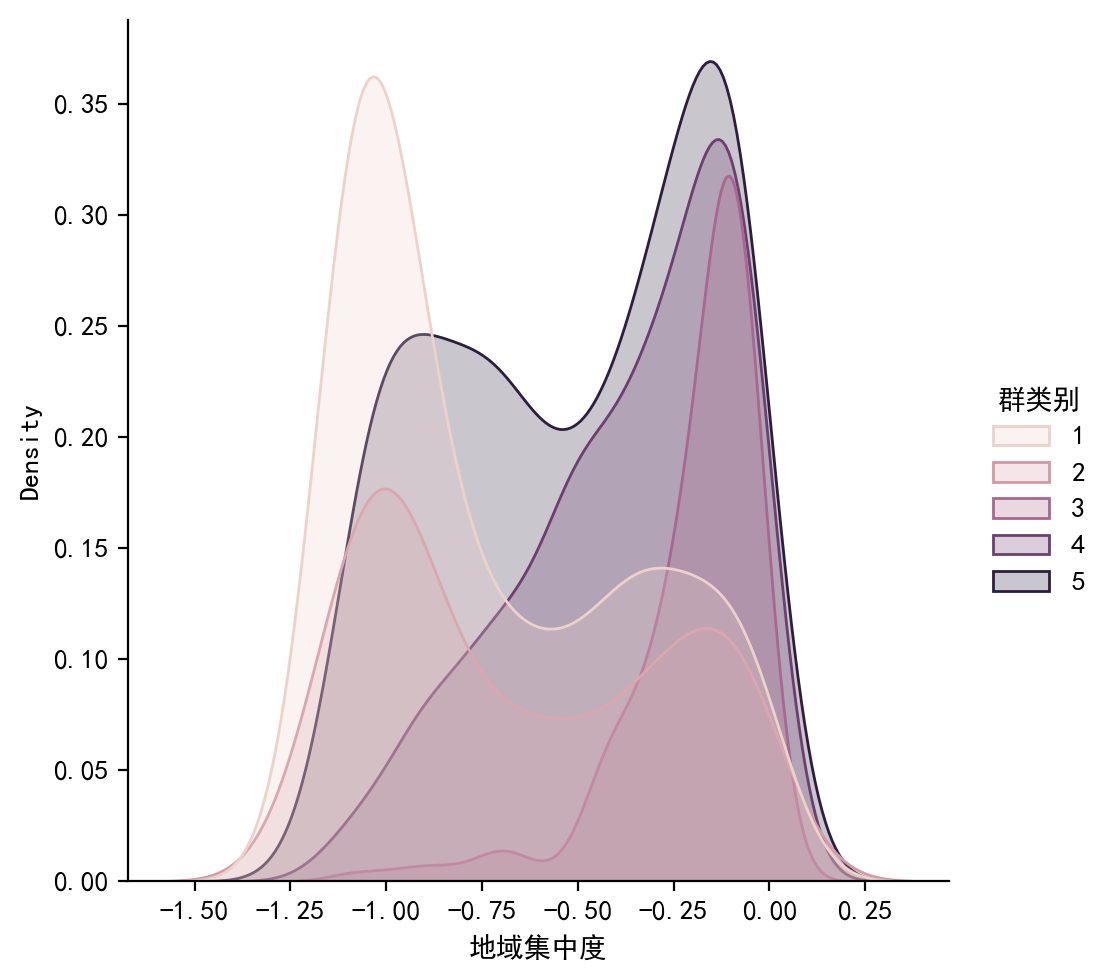

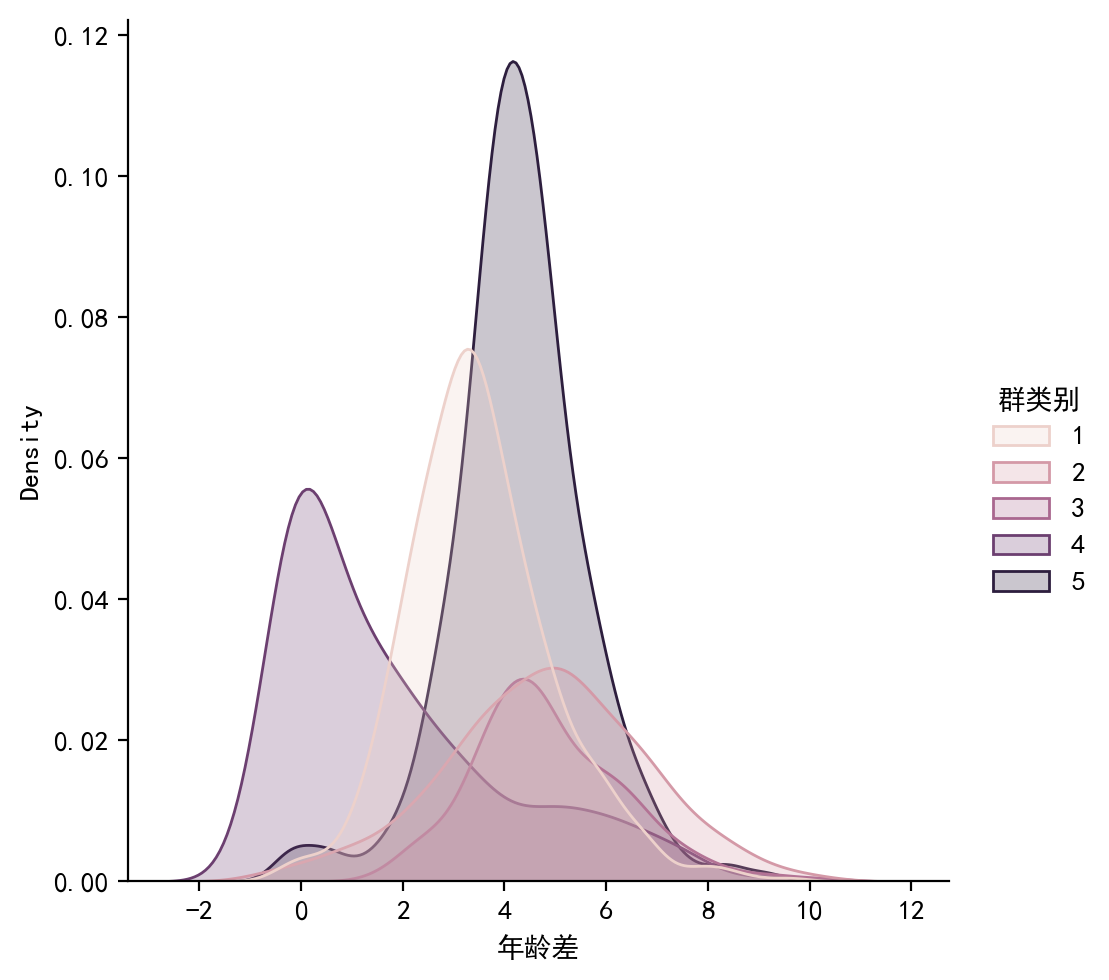

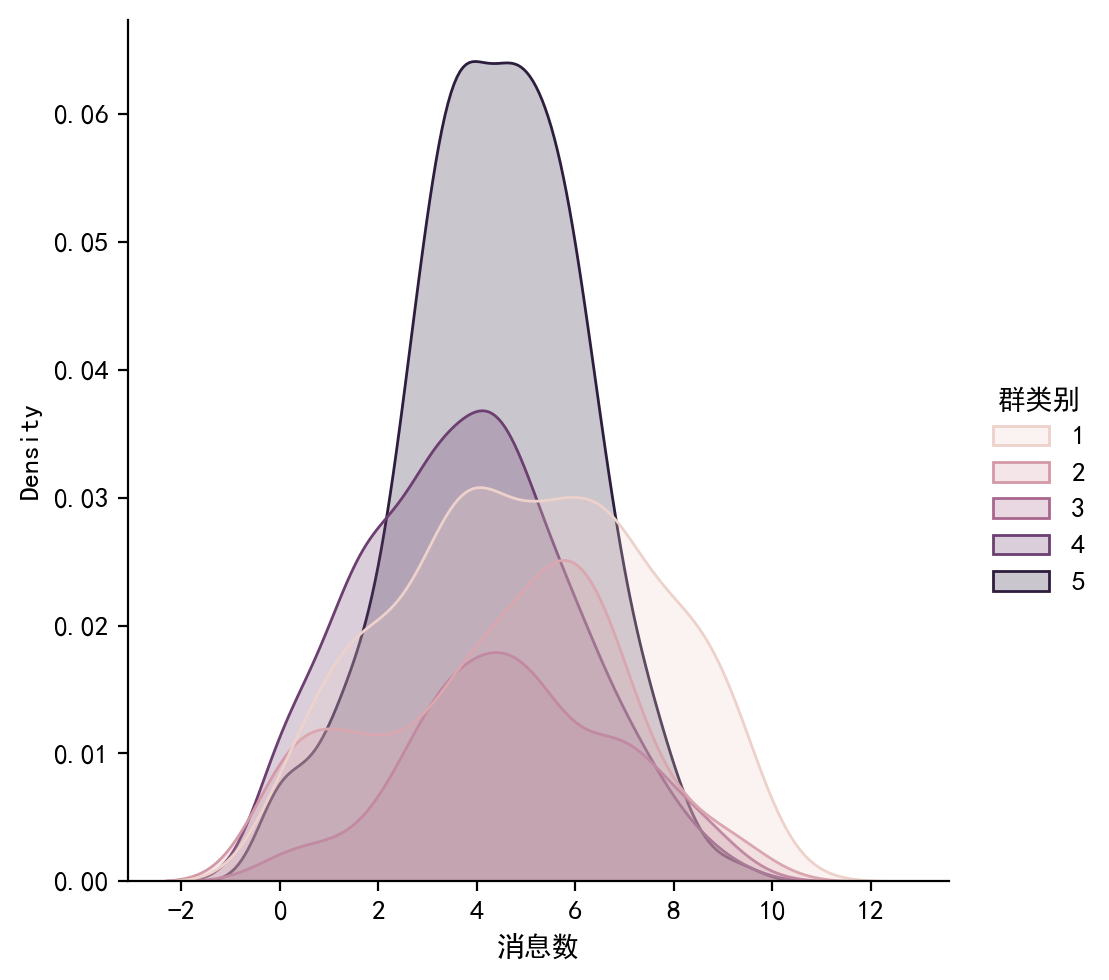

In [8]:
# Q5-boxcox

for idx_col, col in enumerate(cols):
    print(f'Column: {col}')
    lmb = boxcox(data[col])[1]
    trans_cols = {c: (lambda x: boxcox(x, lmbda=lmb)) if c == col else
                  (lambda x: x) for c in data.columns}
    sns.displot(data.transform(trans_cols),
                x=col, hue='群类别', kind='kde', fill=True)
    components = [[i, g[col].transform(
        lambda x: boxcox(
            x, lmbda=lmb))] for i, g in data[['群类别', col]].groupby('群类别')]
    # Test the normality
    print('Normal Test:')
    for gid, group in components:
        norm_test_res = hypothesis_test(normaltest(group)[1])
        print(f'group {gid}: {norm_test_res}')

    # Test the homogeneity of variances
    print('Homogeneity Test:')
    stds = [[gid, group.std()] for gid, group in components]
    max_std, min_std = max(stds, key=lambda x: x[1])[1], min(stds, key=lambda x: x[1])[1]
    ratio = max_std / min_std
    print('Ratio of largest to smallest group std:\n' +
          f'{max_std:.5f} / {min_std:.5f} = {ratio:.5f} ' +
          ('> 2:1 (Reject Homogeneity)' if ratio >= 2 else
           '< 2:1 (Accept Homogeneity)'))
    print('ANOVA Test:')
    print(hypothesis_test(f_oneway(*[g for _, g in components]).pvalue))
    print()

Column: 地域集中度
Normal Test:
group 1: p_value = 3.7236e-20 < 0.01 (Reject H0)
group 2: p_value = 6.4155e-131 < 0.01 (Reject H0)
group 3: p_value = 7.3624e-19 < 0.01 (Reject H0)
group 4: p_value = 2.8545e-11 < 0.01 (Reject H0)
group 5: p_value = 0.0000e+00 < 0.01 (Reject H0)
Homogeneity Test:
Ratio of largest to smallest group std:
0.29251 / 0.15191 = 1.92555 < 2:1 (Accept Homogeneity)
ANOVA Test:
p_value = 5.3403e-94 < 0.01 (Reject H0)

Column: 年龄差
Normal Test:
group 1: p_value = 1.2419e-10 < 0.01 (Reject H0)
group 2: p_value = 7.6243e-01 > 0.01 (Accept H0)
group 3: p_value = 2.2480e-04 < 0.01 (Reject H0)
group 4: p_value = 1.4732e-16 < 0.01 (Reject H0)
group 5: p_value = 7.5221e-08 < 0.01 (Reject H0)
Homogeneity Test:
Ratio of largest to smallest group std:
2.15635 / 1.31917 = 1.63462 < 2:1 (Accept Homogeneity)
ANOVA Test:
p_value = 3.2602e-151 < 0.01 (Reject H0)

Column: 消息数
Normal Test:
group 1: p_value = 2.1872e-21 < 0.01 (Reject H0)
group 2: p_value = 9.5681e-08 < 0.01 (Reject H0)
g

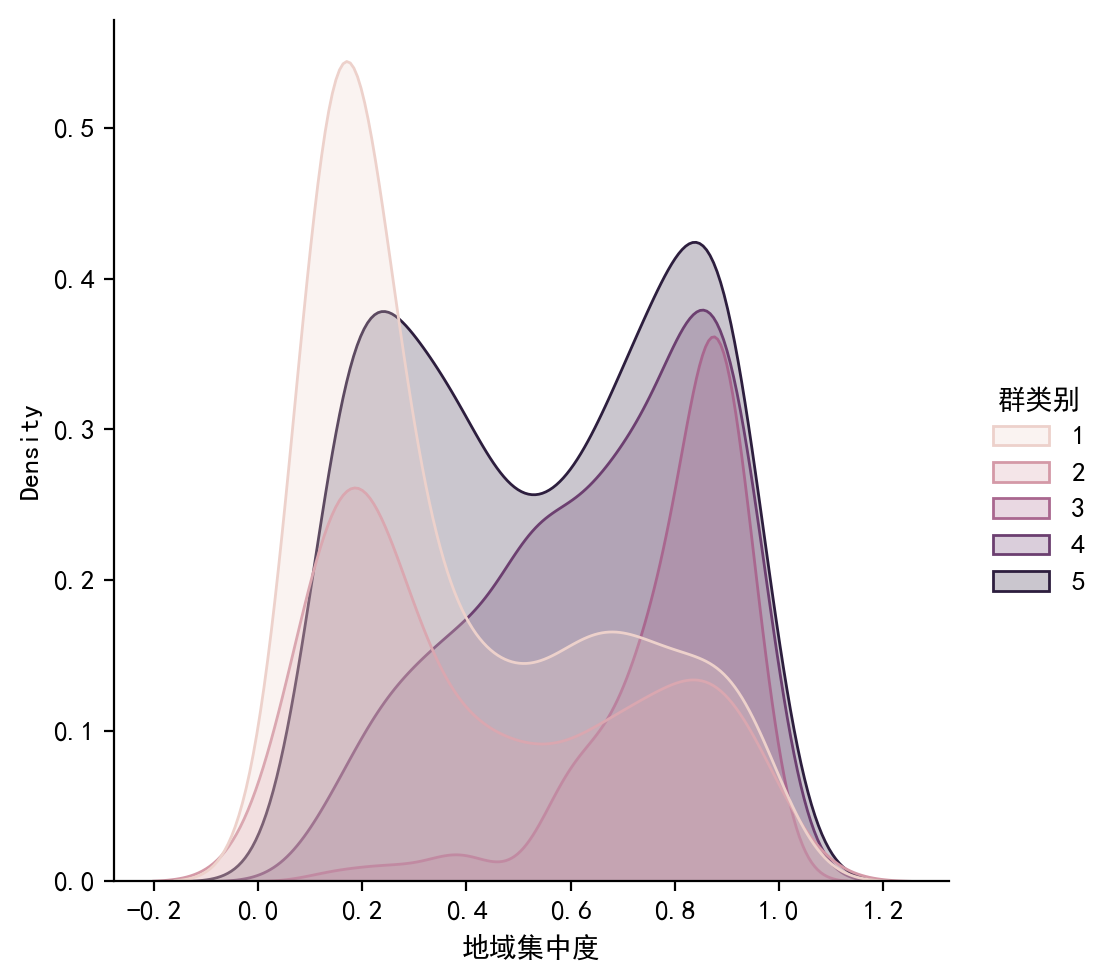

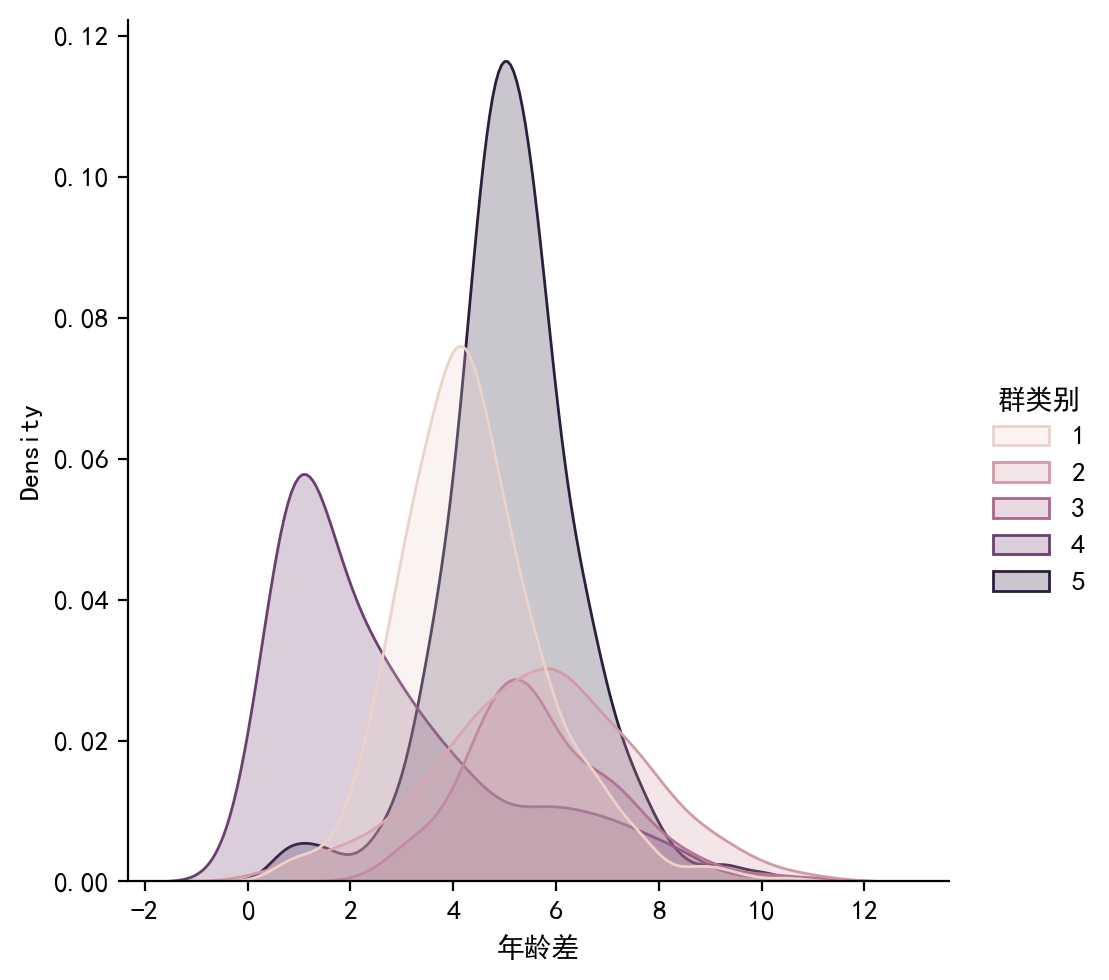

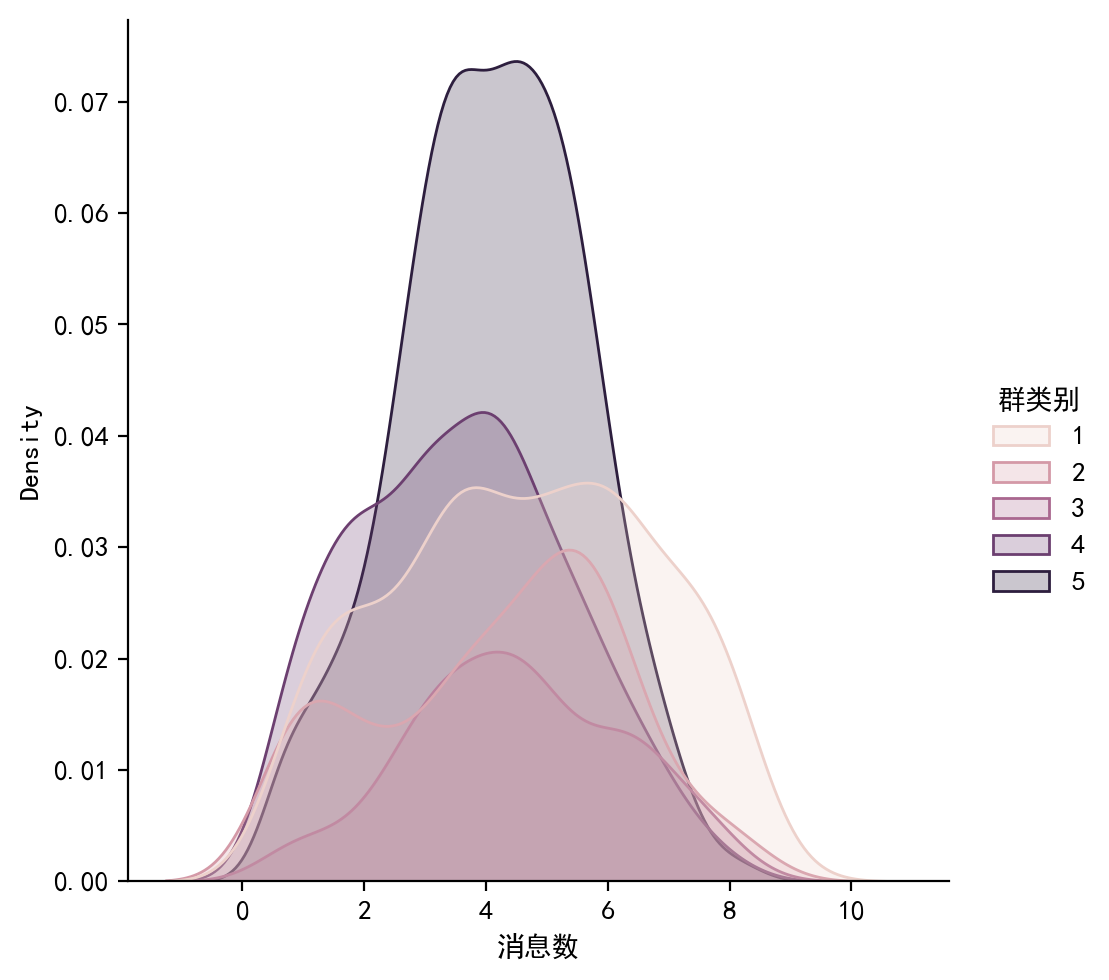

In [9]:
# Q5-yeojohnson

for idx_col, col in enumerate(cols):
    print(f'Column: {col}')
    lmb = yeojohnson(data[col])[1]
    trans_cols = {c: (lambda x: yeojohnson(x, lmbda=lmb)) if c == col else
                  (lambda x: x) for c in data.columns}
    sns.displot(data.transform(trans_cols),
                x=col, hue='群类别', kind='kde', fill=True)
    components = [[i, g[col].transform(
        lambda x: yeojohnson(
            x, lmbda=lmb))] for i, g in data[['群类别', col]].groupby('群类别')]
    # Test the normality
    print('Normal Test:')
    for gid, group in components:
        norm_test_res = hypothesis_test(normaltest(group)[1])
        print(f'group {gid}: {norm_test_res}')

    # Test the homogeneity of variances
    print('Homogeneity Test:')
    stds = [[gid, group.std()] for gid, group in components]
    max_std, min_std = max(stds, key=lambda x: x[1])[1], min(stds, key=lambda x: x[1])[1]
    ratio = max_std / min_std
    print('Ratio of largest to smallest group std:\n' +
          f'{max_std:.5f} / {min_std:.5f} = {ratio:.5f} ' +
          ('> 2:1 (Reject Homogeneity)' if ratio >= 2 else
           '< 2:1 (Accept Homogeneity)'))
    print('ANOVA Test:')
    print(hypothesis_test(f_oneway(*[g for _, g in components]).pvalue))
    print()

(b) **(25 points) Do the one one-way ANOVA on the 3 columns you choose. Do these feature columns vary significantly? Visualize the results.**

从上面三列的 ANOVA 的 p-value 结果可以看出，不管是否经过变换，这三个特征均拒绝原假设 $H_0$：所有组的均值都相等，并且都非常显著。
也就是说，这三种特征在不同群类别下的均值差别明显。

ANOVA 的计算过程见上面的程序输出，可视化过程也在上面的图片中展示。

并且我们对数据使用 Box-Cox 和 Johnson 变换，从结果可以看出正态性改善依然比较有限，说明这些变换也并不是万能的。
不过这两个变换是对同调性也有明显改善，Johnson 变换下甚至三种特征都已经符合同调性了。